# CS4487 Machine Learning | City University of Hong Kong
## Group Assignment - until 2019.12.13
- Tim Löhr       , EID: 40126684 
- Timo Bohnstedt , EID:
- Karina         , EID:

### Try to get the best possible accuracy for the Cifar 10 task

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import time
import csv
from tqdm import tqdm
import os
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device is " + str(device))

Device is cpu


# 1.0 Preprocessing of the Data
## 1.1 - Load the data from PyTorch and transform it

In [2]:
transformer_train = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]),
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip()
])

transformer_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]),
])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer_test)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

x_test_torch = torch.Tensor(np.load('./test_data/y_test.npy')).permute(0, 3, 1, 2)
x_test_torch.size()

Files already downloaded and verified
Files already downloaded and verified


torch.Size([12000, 3, 32, 32])

## 1.2 - Visualize the images

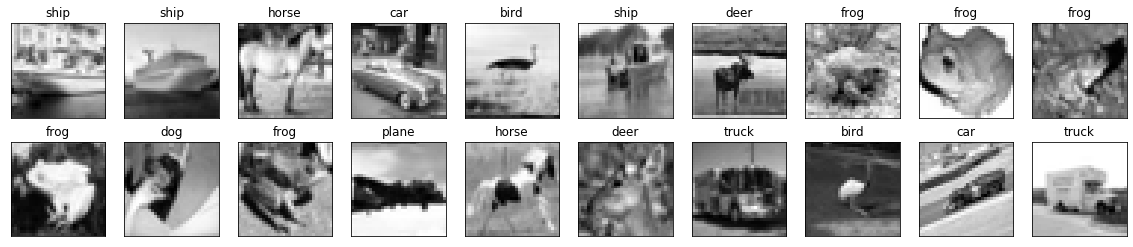

In [3]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(images[i][0], cmap='gray')
    ax.set_title(classes[labels[i].item()])

# 2.0 - Neural Network
## 2.1 - CNN 

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

## 2.2 - VGG Neural Network

In [5]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGGNet(nn.Module):
    def __init__(self, vgg_name):
        super(VGGNet, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        input_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(input_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                input_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [6]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out

In [7]:
class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out

## 2.3 - Dense Neural Network

In [8]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

#### Use the Dense 121 Net to train

In [9]:
def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

In [10]:
# Basic CNN Model
#model = CNN()

# VGG 16 Model
model = DenseNet121()

model = model.to(device)

print(model)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

#### Loss function and Optimizer

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

#### Functions to make it easier to load and train

In [12]:
# Model saved as "model.pt" in this directory
# Try to load the model to avoid training again

def load_model(model):
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('models')
    checkpoint = torch.load('models/model_dense121.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    acc = checkpoint['acc']
    
# To reduce the calculations in the loop
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        
        loss = loss_fn(yhat, x)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

# 3.0 - Model Training
## 3.1 - Trainings Function

In [ ]:
try:
    # Try to load the model
    load_model(model)
    print("Model loaded successfully")
except:
    # Train the model if model, parameters or epochs changed
    
    model.train()
    
    epochs = 1
    running_loss_history = []
    running_correct_history = []
    validation_running_loss_history = [] 
    validation_running_correct_history = []
    
    training_start_time = time.time()
    
    train_step = make_train_step(model, loss_fn, optimizer)
    
    
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0
        running_correct = 0.0
        validation_loss = 0.0
        validation_running_correct = 0.0

        for x_batch, y_batch in tqdm(training_loader): 
            
            x_tensor_batch = x_batch.to(device)
            y_tensor_batch = y_batch.to(device)
            
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_tensor_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)

            running_correct += torch.sum(preds == y_tensor_batch.data)
            train_loss += loss.item()

        else:    
            with torch.no_grad():
                for x_val_tensor_batch, y_val_tensor_batch in validation_loader:
                    
                    val_outputs = model(x_val_tensor_batch)
                    val_loss = loss_fn(val_outputs, y_val_tensor_batch)

                    _, val_preds = torch.max(val_outputs, 1)
                    
                    validation_loss += val_loss.item()
                    validation_running_correct += torch.sum(val_preds == y_val_tensor_batch.data) 

        epoch_loss = train_loss / len(training_loader)
        epoch_acc = running_correct.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)

        val_epoch_loss = validation_loss / len(validation_loader)
        val_epoch_acc = validation_running_correct.float() / len(validation_loader)
        validation_running_loss_history.append(val_epoch_loss)
        validation_running_correct_history.append(val_epoch_acc)

        print("="*20)
        print("epoch: ", epoch + 1)
        print("training loss: {:.5f}, acc: {:2f}%".format(epoch_loss, epoch_acc))
        print("validation loss: {:.5f}, acc: {:2f}%".format(val_epoch_loss, val_epoch_acc))
        print("time: {:.2f}s".format(time.time() - start_time))
        start_time = time.time()

    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),       
        'loss': loss,
        'acc': max(validation_running_correct_history)}
        , 'models/model_vgg.pt')

  0%|          | 0/500 [00:00<?, ?it/s]

==> Resuming from checkpoint..


 17%|█▋        | 86/500 [38:58<3:16:29, 28.48s/it]

## 3.2 - Accuracy Function

In [ ]:
# Function to calculate from a pytorch dataset
def accuracy(model, dataset):
    with torch.no_grad():
        model = model.eval()  
        
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=len(dataset), shuffle=True)
        images, labels = next(iter(loader))
        out = model(images)
        
        _, arg_maxs = torch.max(out.data, dim=1) 
        num_correct = torch.sum(labels==arg_maxs)
        acc = (num_correct / len(labels))*100

        model = model.train()  
        print(str(round(acc.item(), 2)) + "%")

### Reached Accuracy of 81.68% with the Validation Set

In [ ]:
accuracy(model, validation_dataset)

# 4.0 - Test Set prediction into CSV
## 4.1 - Predict & Safe CSV

In [ ]:
try:
    y_pred = model(x_test_torch)

    _, y_pred_max = torch.max(y_pred, 1)

    header = "Index,Category"

    np.savetxt("results_dense121.csv", np.column_stack((np.arange(0,12000), y_pred_max.numpy())), 
               delimiter=",", 
               fmt='%s', 
               header=header, 
               comments='')
    print("Saved results.csv successfully")
except:
    print("Failed to save results.csv")

In [ ]:
df = pd.read_csv('results.csv')
df.head()

In [ ]:
# PyTorch dataset for the provided test data
class TestDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)

In [ ]:
batch_size = 20

y_test_torch = torch.Tensor(df.Category.values)

test_data = TestDataset(x_test_torch.float(), y_test_torch.int())
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=batch_size)

## 4.2 - Print the estimated classes for the test set

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(images[i][0], cmap='gray')
    ax.set_title(classes[labels[i].item()])